In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = "../data"
surrogate_data_folder = os.path.join(data_folder, "surrogate", "data")
surrogate_static_folder = os.path.join(data_folder, "surrogate", "static")
log_folder = os.path.join(data_folder, "logs")

output_images_folder = 'images'
if not os.path.exists(output_images_folder):
    os.makedirs(output_images_folder)

## What to display ?

- **1. Curve of performance runs during search process (`surrogate/data`) :**
    - best solution score (in means from 5 runs)
    - comparisons of different orders
    - comparisons of different LS iterations per orders
    - extract times of computation (`data/logs`)
    - surrogate model performance during training (r²)


- **2. From only best last solutions found displays :**
    - bar plot of best attribute selected for classification per order
    - same for the two orders 

### 1. Curve of performances runs during search process (`surrogate/data`)

In [23]:
# fixed parameters
ILS = 1000
POP = 20
N_RUNS = 5
SS = 50 # start surrogate training after at least 50 real evaluations
SE = 10 # train every 10 real evaluations

In [24]:
def extract_params(filename):
    #pop_size = filename.split('-')[2].replace('POP_', '')
    ls_iter = filename.split('-')[3].replace('LS_', '')
    s_order = filename.split('-')[5].replace('SO_', '')

    return int(ls_iter), int(s_order)

In [25]:
files = os.listdir(surrogate_data_folder)

data_results = {}
static_results = {}

# extract static result
for LS in [100, 500, 1000]: 
    
    LS_files = [ result for result in os.listdir(surrogate_static_folder) if f'LS_{LS}-' in result ]

    for f in LS_files:
        filepath = os.path.join(surrogate_static_folder, f)

        with open(filepath, 'r') as ff:

            max_score = 0.
            scores = []

            for line in ff.readlines()[1:ILS+1]:
                cscore = float(line.split(';')[-1])

                if cscore > max_score:
                    max_score = cscore

                scores.append(max_score)

        if LS not in static_results:
            static_results[LS] = []
            
        static_results[LS].append(scores)

# extract all other results
for i in range(1, N_RUNS + 1):
    for run in [ f for f in files if f"RUN_{i}_performance" in f ]:
        
        key = extract_params(run)
        if key not in data_results:
            data_results[key] = []

        # need to extract the 50 first solution found from surrogate data file
        data_file = os.path.join(surrogate_data_folder, run.replace('_performance.csv', ''))

        max_score = 0.
        scores = []
        with open(data_file, 'r') as f:
            lines = f.readlines()

            for line in lines[1:SS + 1]:
                cscore = float(line.split(';')[-1])

                if cscore > max_score:
                    max_score = cscore
                scores.append(max_score)
        
        with open(os.path.join(surrogate_data_folder, run), 'r') as f:
            lines = f.readlines()

            for index, line in enumerate(lines[:ILS - SS]):
                #print(f'{index} => {run}')
                #print(line)
                cscore = float(line.split(';')[-2])

                if cscore > max_score:
                    max_score = cscore

                scores.append(max_score)

        # append run data into dictionnary with its key
        data_results[key].append(scores)

In [26]:
for k in sorted(data_results.keys()):
    print(f'{k} has {len(data_results[k])} runs')

(100, 1) has 5 runs
(100, 2) has 5 runs
(500, 1) has 5 runs
(500, 2) has 5 runs
(1000, 1) has 5 runs
(1000, 2) has 5 runs


In [27]:
for k in sorted(static_results.keys()):
    print(f'{k} has {len(static_results[k])} runs')

100 has 5 runs
500 has 4 runs
1000 has 5 runs


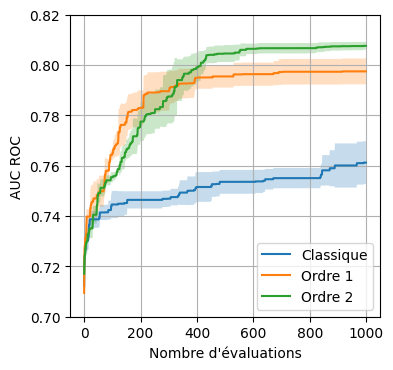

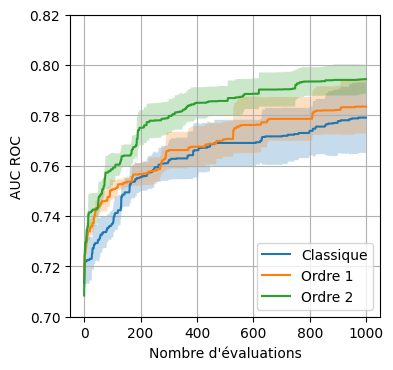

<Figure size 400x400 with 0 Axes>

In [28]:
n_LS = 100

for n_LS in [100, 500, 1000]:
    fig = plt.figure(dpi=100, figsize=(4, 4))
    ax = fig.add_subplot(111)
    #ax.set_title(f'Surroggate - LS = {n_LS}')

    # display static results
    data = np.array(static_results[n_LS])

    means = data.mean(axis=0)
    confidences = (1.9 * data.std(axis=0)) / np.sqrt(data.shape[0])
            
    ax.plot(means, label=f'Classique')
    ax.fill_between(np.arange(data.shape[1]), means-confidences, means+confidences, alpha=.25)

    for k in sorted(data_results.keys()):
        ls_iter, order = k

        if ls_iter == n_LS:
            
            data = np.array(data_results[k])

            means = data.mean(axis=0)
            confidences = (1.9 * data.std(axis=0)) / np.sqrt(N_RUNS)
            
            ax.plot(means, label=f'Ordre {order}')
            ax.fill_between(np.arange(1000), means-confidences, means+confidences, alpha=.25)

    ax.grid()
    ax.legend(loc=4)
    ax.set_ylabel('AUC ROC')
    ax.set_xlabel('Nombre d\'évaluations')
    ax.set_ylim(0.7, 0.82)
    # ax.set_yscale('log')
    fig.savefig(os.path.join(output_images_folder, f'out_performance_LS-{n_LS}.pdf'), format='pdf', bbox_inches='tight')
    #plt.show()
fig.clf()

(15, 1000)
(15, 1000)


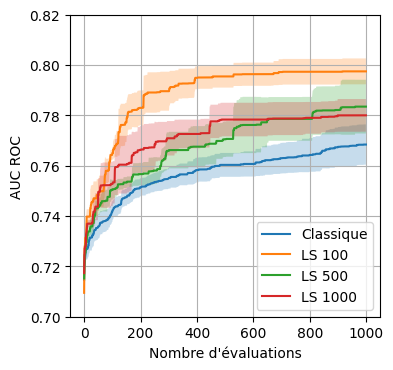

<Figure size 400x400 with 0 Axes>

In [22]:
for o in [1, 2]:
    fig = plt.figure(dpi=100, figsize=(4, 4))
    ax = fig.add_subplot(111)
    #ax.set_title(f'Surrogate - Order = {o}')

    # display static results
    data_list = []
    for k in static_results:
        data_list = data_list + static_results[k]
        
    data = np.array(data_list)

    means = data.mean(axis=0)
    confidences = (1.9 * data.std(axis=0)) / np.sqrt(data.shape[0])
            
    ax.plot(means, label=f'Classique')
    ax.fill_between(np.arange(data.shape[1]), means-confidences, means+confidences, alpha=.25)

    for k in sorted(data_results.keys()):
        ls_iter, order = k

        if o == order:
            
            data = np.array(data_results[k])

            means = data.mean(axis=0)
            confidences = (1.9 * data.std(axis=0)) / np.sqrt(N_RUNS)
            
            ax.plot(means, label=f'LS {ls_iter}')
            ax.fill_between(np.arange(1000), means-confidences, means+confidences, alpha=.25)

    ax.grid()
    ax.legend(loc=4)
    ax.set_ylabel('AUC ROC')
    ax.set_xlabel('Nombre d\'évaluations')
    ax.set_ylim(0.7, 0.82)
    # ax.set_yscale('log')
    fig.savefig(os.path.join(output_images_folder, f'out_performance_SO-{o}.pdf'), format='pdf', bbox_inches='tight')
    #plt.show()
fig.clf()

### 2. Curve of model training scores

In [29]:
files = os.listdir(surrogate_data_folder)

data_results = {}
for i in range(1, N_RUNS + 1):
    for run in [ f for f in files if f"RUN_{i}_performance" in f ]:
        
        key = extract_params(run)
        if key not in data_results:
            data_results[key] = []

        # need to extract the 50 first solution found from surrogate data file
        data_file = os.path.join(surrogate_data_folder, run.replace('_performance.csv', ''))

        scores = []
        
        with open(os.path.join(surrogate_data_folder, run), 'r') as f:
            lines = f.readlines()

            for index, line in enumerate(lines[:ILS - SS]):
                #print(f'{index} => {run}')
                #print(line)
                scores.append(float(line.split(';')[4]))

        # append run data into dictionnary with its key
        data_results[key].append(scores)

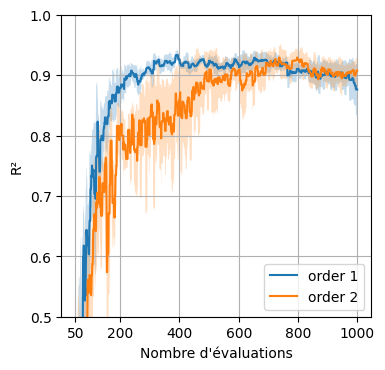

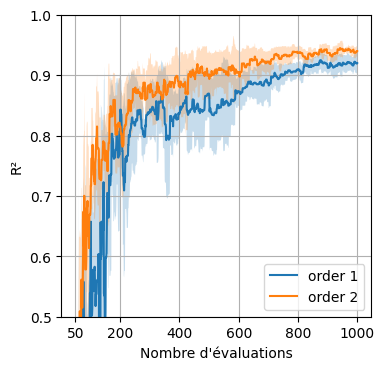

<Figure size 400x400 with 0 Axes>

In [30]:
n_LS = 100

for n_LS in [100, 500, 1000]:
    fig = plt.figure(dpi=100, figsize=(4, 4))
    ax = fig.add_subplot(111)
    #ax.set_title(f'Surrogate model - LS {n_LS}')

    for k in sorted(data_results.keys()):
        ls_iter, order = k

        if ls_iter == n_LS:
            
            data = np.array(data_results[k])

            means = data.mean(axis=0)
            confidences = (1.9 * data.std(axis=0)) / np.sqrt(N_RUNS)
            
            ax.plot(means, label=f'order {order}')
            ax.fill_between(np.arange(ILS - SS), means-confidences, means+confidences, alpha=.25)

    ax.grid()
    ax.legend(loc=4)
    ax.set_ylabel('R²')
    ax.set_xlabel('Nombre d\'évaluations')
    ax.set_ylim(0.5, 1)
    ax.set_xticks([0, 150, 350, 550, 750, 950]) 
    ax.set_xticklabels([50, 200, 400, 600, 800, 1000]) 
    # ax.set_yscale('log')
    fig.savefig(os.path.join(output_images_folder, f'model_scores_LS-{n_LS}.pdf'), format='pdf', bbox_inches='tight')
    #plt.show()
fig.clf()

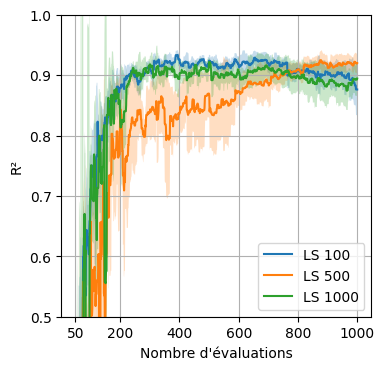

<Figure size 400x400 with 0 Axes>

In [31]:
for o in [1, 2]:
    fig = plt.figure(dpi=100, figsize=(4, 4))
    ax = fig.add_subplot(111)
    #ax.set_title(f'Surrogate model - order {o}')

    for k in sorted(data_results.keys()):
        ls_iter, order = k

        if o == order:
            
            data = np.array(data_results[k])

            means = data.mean(axis=0)
            confidences = (1.9 * data.std(axis=0)) / np.sqrt(N_RUNS)
            
            ax.plot(means, label=f'LS {ls_iter}')
            ax.fill_between(np.arange(ILS - SS), means-confidences, means+confidences, alpha=.25)

    ax.grid()
    ax.legend(loc=4)
    ax.set_ylabel('R²')
    ax.set_xlabel('Nombre d\'évaluations')
    ax.set_ylim(0.5, 1)
    
    ax.set_xticks([0, 150, 350, 550, 750, 950]) 
    ax.set_xticklabels([50, 200, 400, 600, 800, 1000]) 
    # ax.set_yscale('log')
    fig.savefig(os.path.join(output_images_folder, f'model_scores_SO-{o}.pdf'), format='pdf', bbox_inches='tight')
    #plt.show()
fig.clf()

### 3. Display more selected attributes

In [32]:
results_folder = os.path.join(data_folder, 'results')
results_file = os.path.join(results_folder, 'optimization_comparisons_attributes.csv')

In [33]:
all_solutions = {}
with open(results_file, 'r') as f:
    for line in f.readlines():
        order = line.split(';')[0].split('-')[5].replace('SO_', '')
        ls_iter = line.split(';')[0].split('-')[3].replace('LS_', '')
        key = (int(ls_iter), int(order))
        data_line = line.split(';')[2].replace('[', '').replace(']', '')
        binary_sol = list(map(int, data_line.split(' ')))

        if key not in all_solutions:
            all_solutions[key] = []

        all_solutions[key].append(binary_sol)

#### Global occurences

In [34]:
binary_sols = []
binary_sol_orders = {}
for k in all_solutions:
    ls_iter, order = k

    if order not in binary_sol_orders:
        binary_sol_orders[order] = []

    for sol in all_solutions[k]:
        binary_sols.append(sol)

        binary_sol_orders[order].append(sol)

In [36]:
binary_sum = np.sum(binary_sols, axis=0)

# overall
fig = plt.figure(dpi=100, figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
#ax.set_title('Surrogate - attributes choices')
ax.bar(np.arange(1, len(binary_sum) + 1), binary_sum, label='All')
ax.set_xticks(np.arange(1, len(binary_sum) + 1))
ax.set_ylabel('Occurences')
ax.set_xlabel('Index de l\'attribut')
ax.set_ylabel('Occurences', fontsize=14)
ax.set_xlabel('Index de l\'attribut', fontsize=14)
fig.savefig(os.path.join(output_images_folder, f'attributes_occurences.pdf'), format='pdf', bbox_inches='tight')
fig.clf()

# for each order
fig = plt.figure(dpi=100, figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
#ax.set_title('Surrogate - attributes choices depending of order')

widths = [-0.2, 0.2]
for order in [1, 2]:
    binary_sum = np.sum(binary_sol_orders[order], axis=0)
    ax.bar(np.arange(1, len(binary_sum) + 1) - widths[order - 1], binary_sum, 0.4, label=f'Ordre {order}')
ax.set_xticks(np.arange(1, len(binary_sum) + 1))
ax.set_ylabel('Occurences', fontsize=14)
ax.set_xlabel('Index de l\'attribut', fontsize=14)
ax.legend(loc=2, fontsize=14)
fig.savefig(os.path.join(output_images_folder, f'attributes_occurences_orders.pdf'), format='pdf', bbox_inches='tight')
fig.clf()


<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>